<a href="https://colab.research.google.com/github/brighamfrandsen/econ484/blob/master/examples/randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
# Import necessary libraries
!git clone https://github.com/brighamfrandsen/econ484.git
%cd econ484/utilities
from preamble import *
%cd ../data

Cloning into 'econ484'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 362 (delta 54), reused 37 (delta 37), pack-reused 288 (from 1)
Receiving objects: 100% (362/362), 8.99 MiB | 4.32 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/econ484/utilities
/content/econ484/data


#### Ensembles of Decision Trees
##### Random forests
###### Building random forests
###### Analyzing random forests

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

This plots the random forests with all the observations on each plot

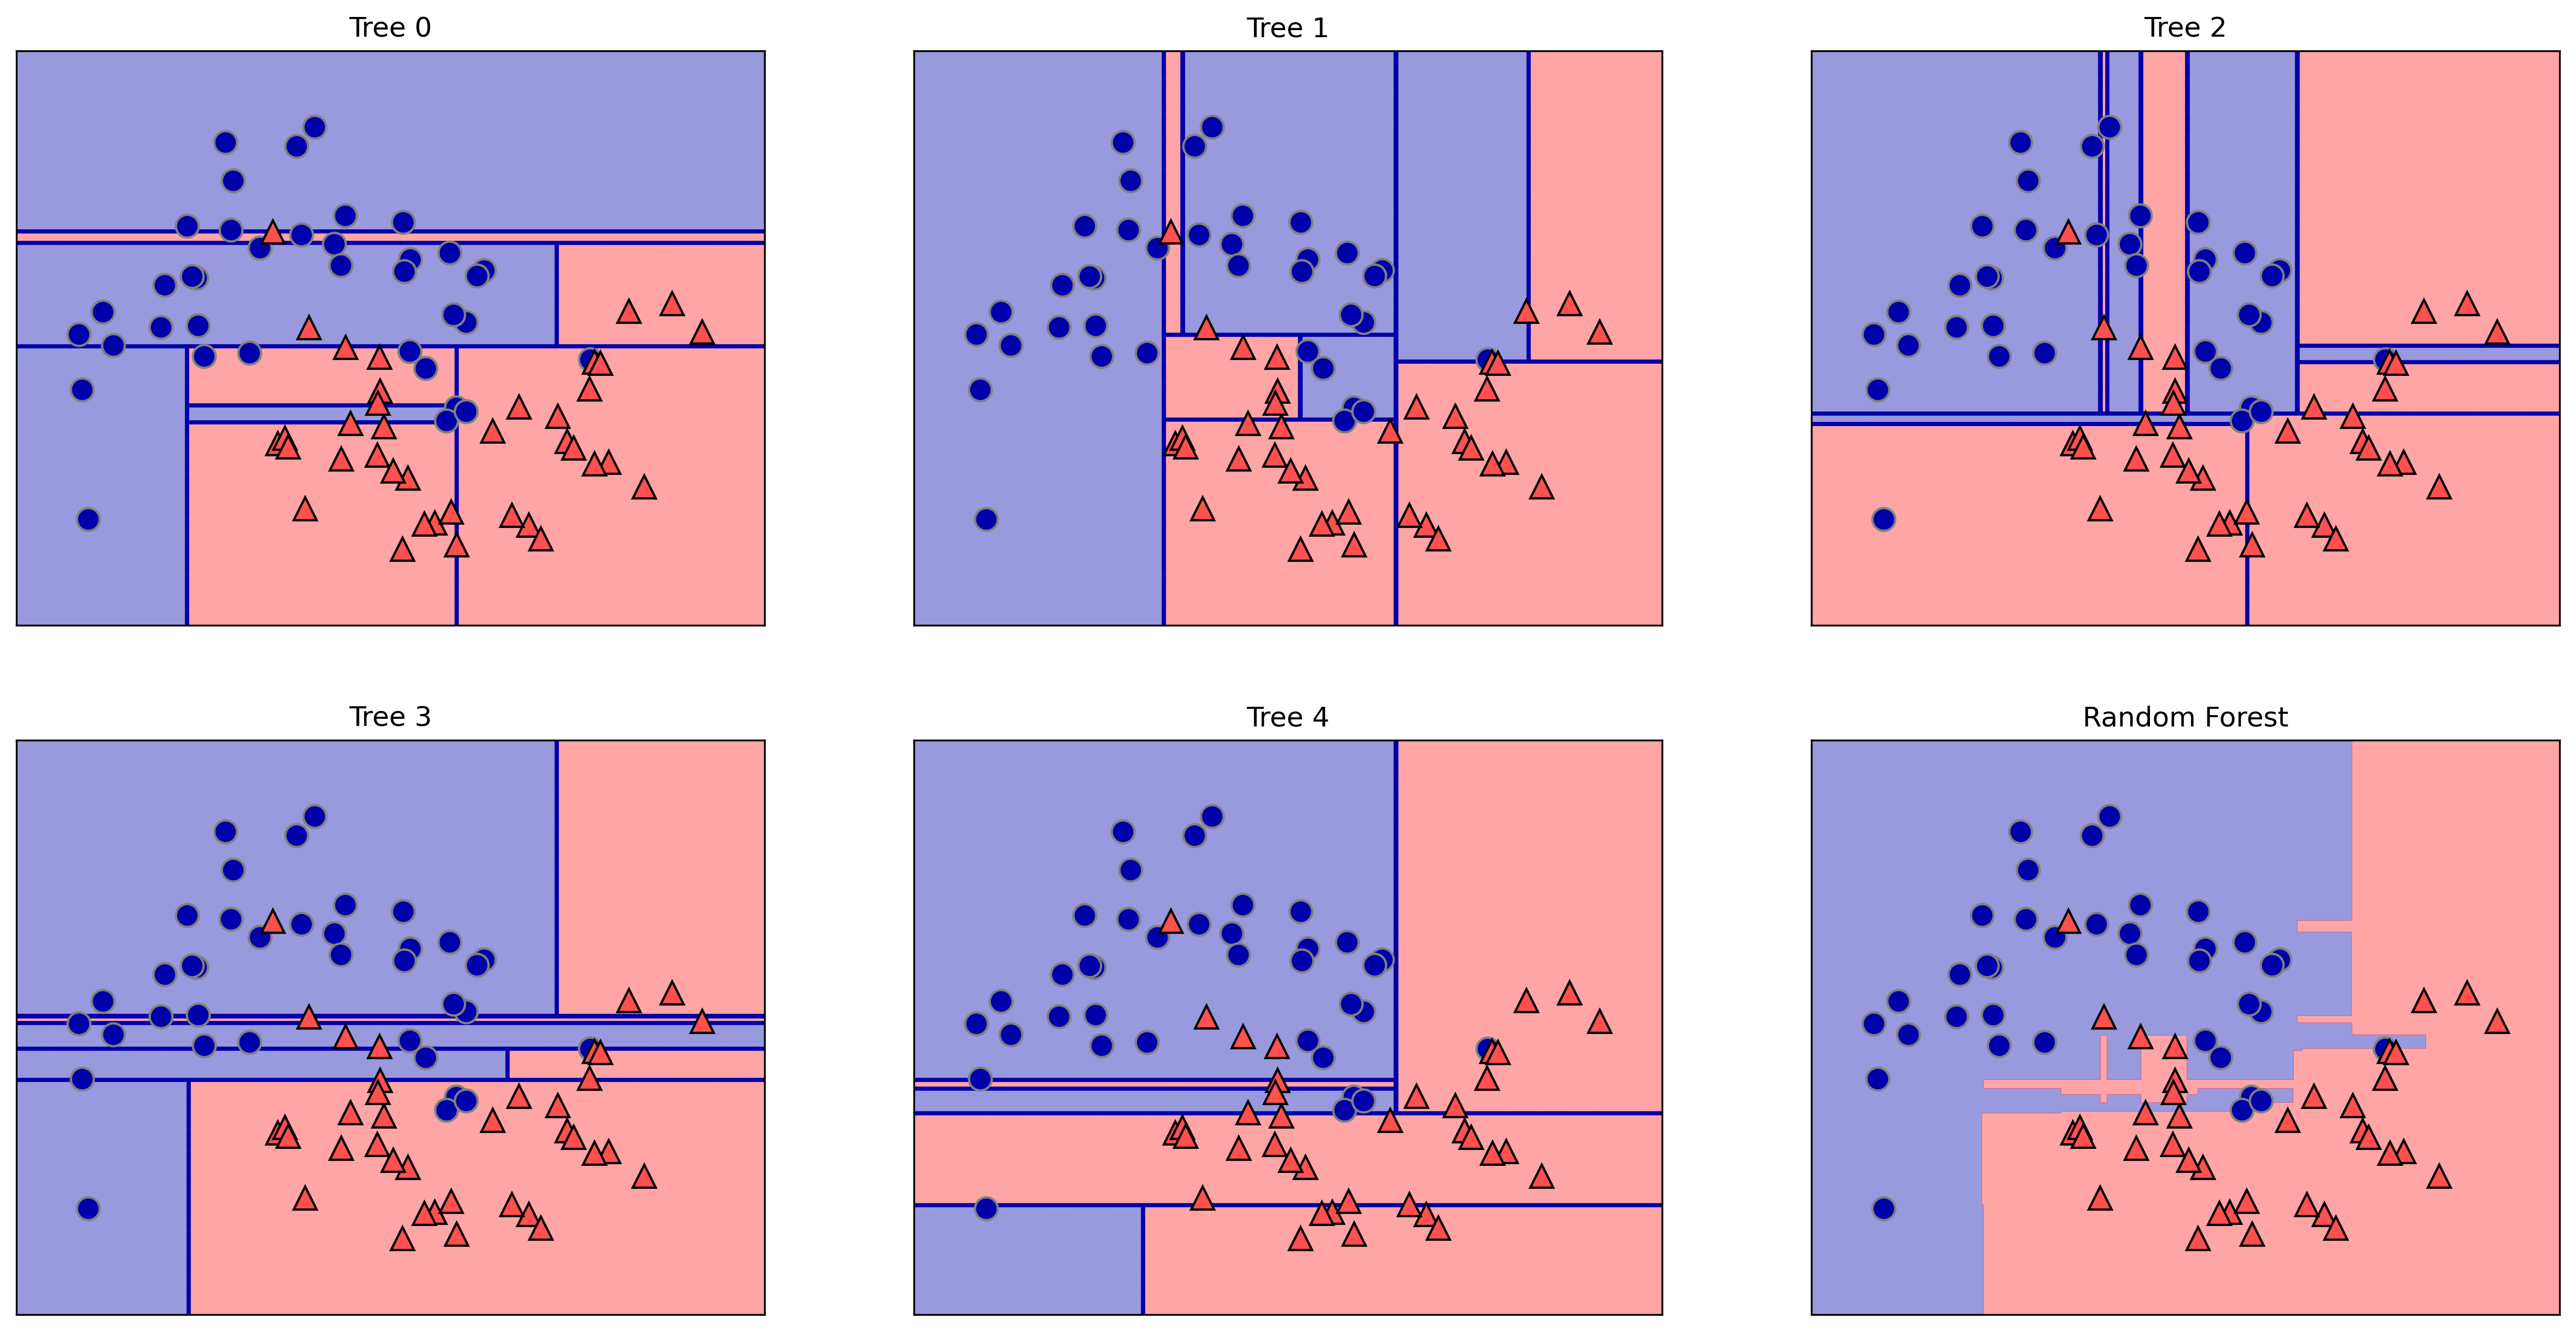

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

This plots only the observations used to train each sub-tree

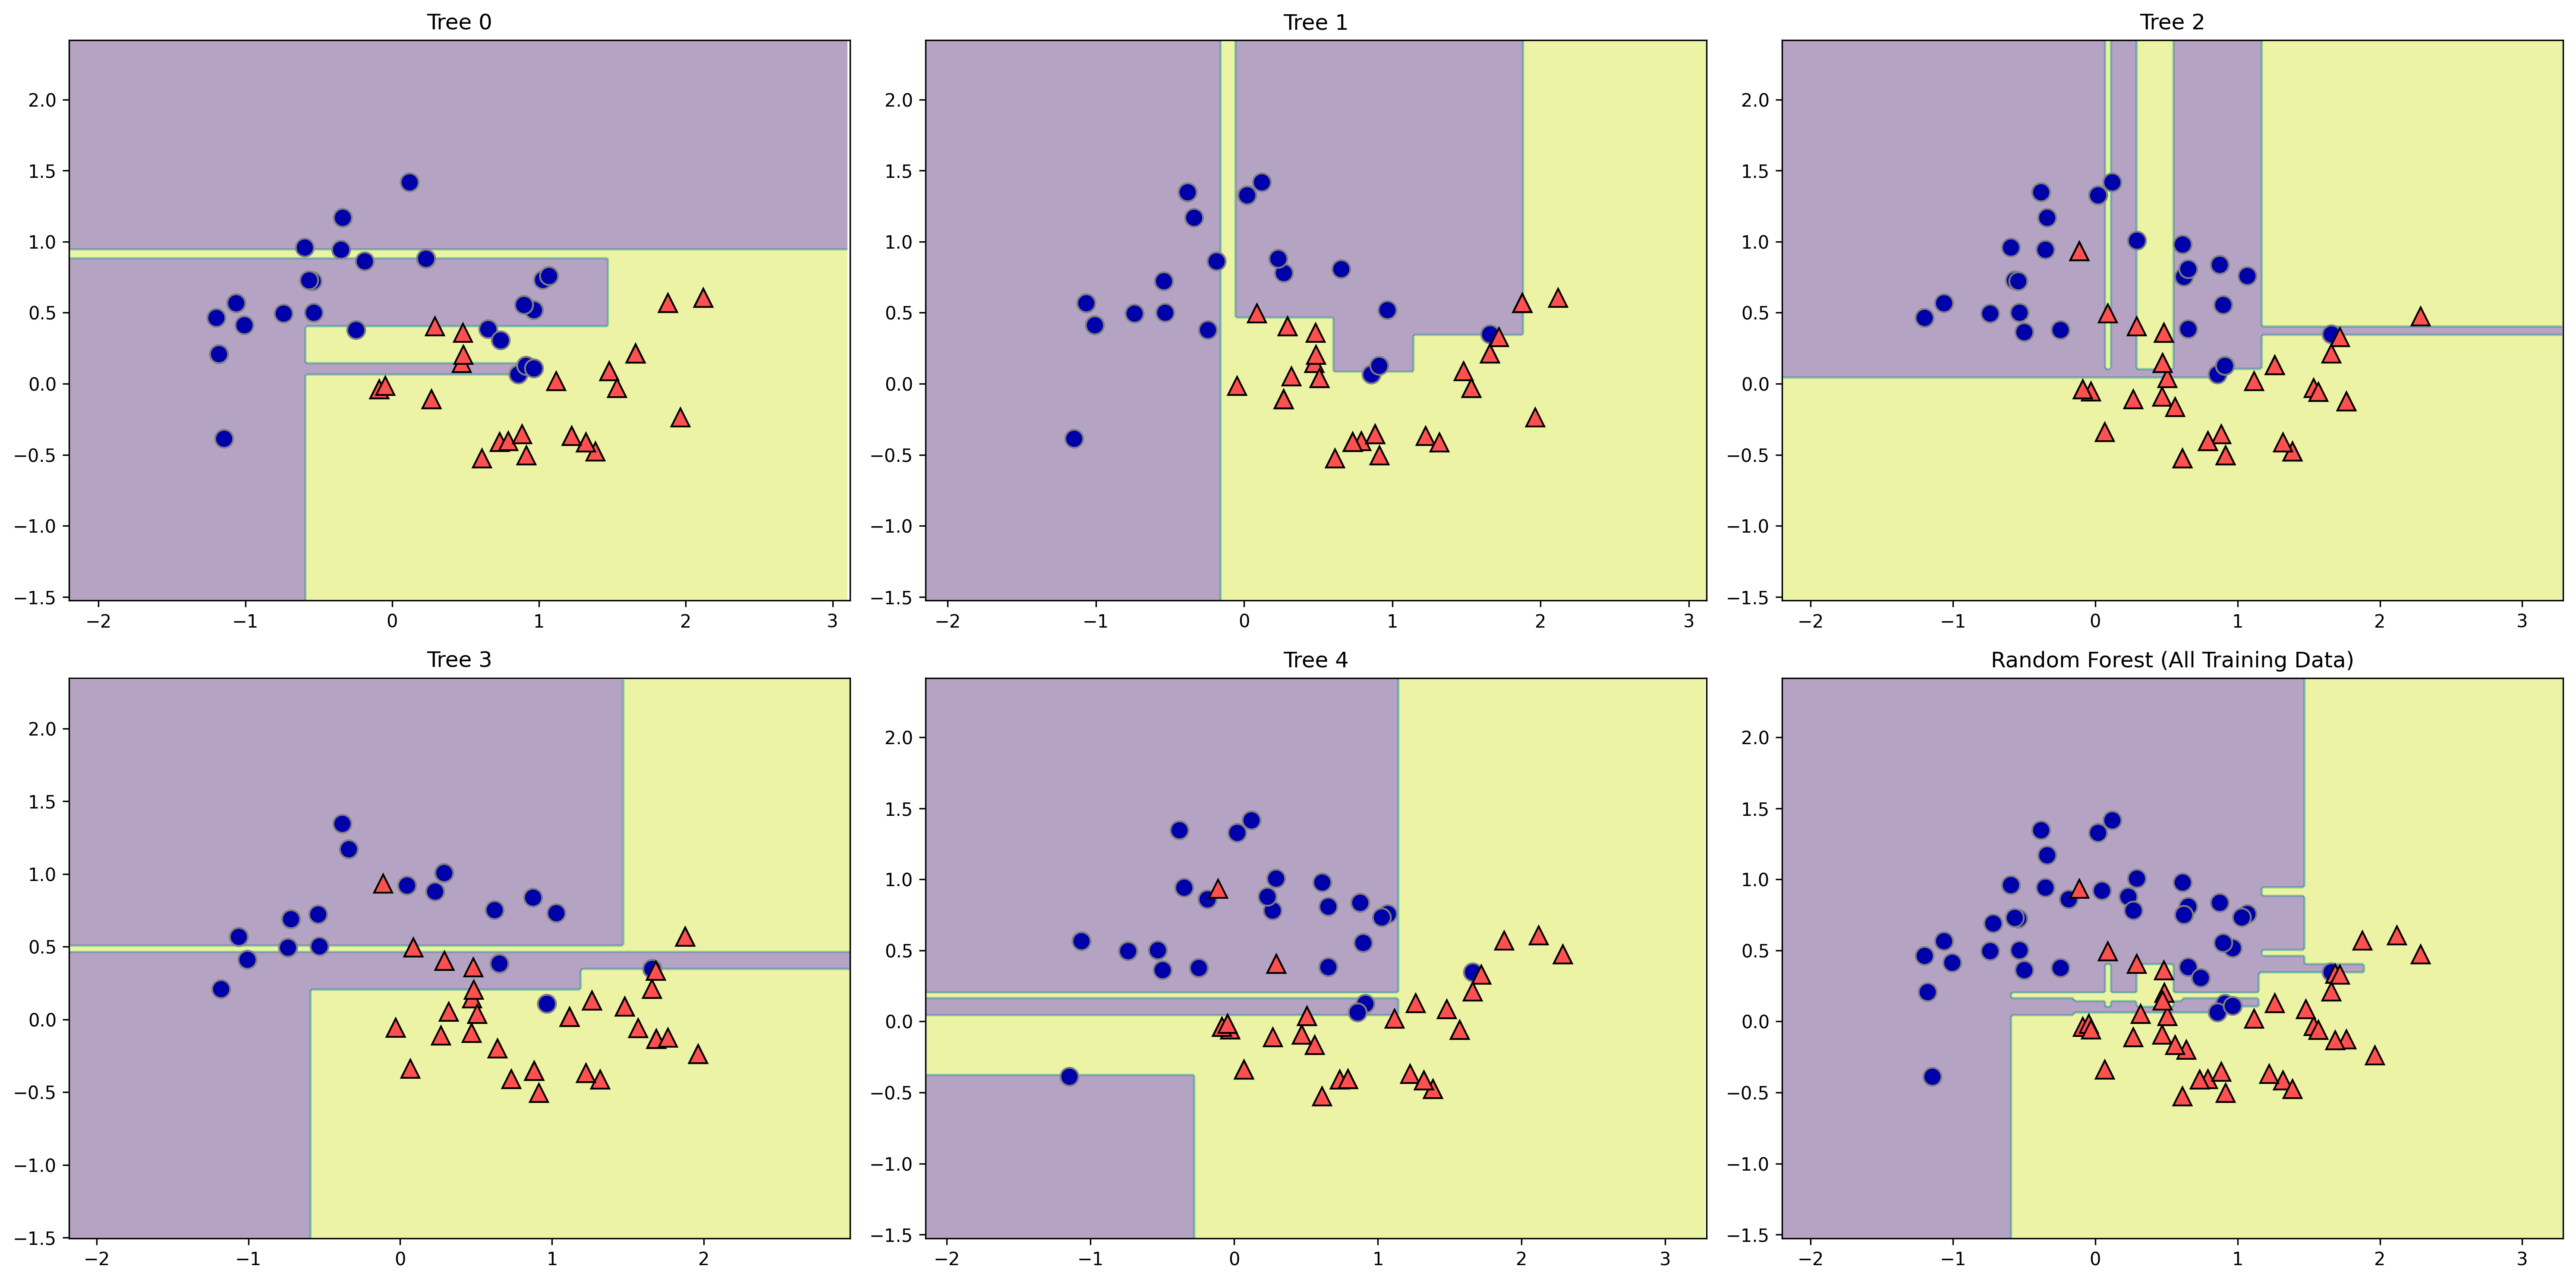

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
import mglearn

# Generate the moon dataset
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train a RandomForest that keeps track of bootstrap samples
forest = RandomForestClassifier(n_estimators=5, random_state=2, bootstrap=True)
forest.fit(X_train, y_train)

# Function to create a custom decision boundary visualization
def plot_decision_boundary(estimator, X, y, ax, title=""):
    h = 0.02  # Step size in the mesh

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class for each point in the mesh
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)

    return ax

# Create the figure
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

# Get bootstrap samples for each tree
# RandomForest doesn't expose this directly, so we need to recreate the bootstrap samples
n_samples = X_train.shape[0]
rng = np.random.RandomState(2)  # Match the random_state of the forest

# Plot each tree with its bootstrap samples
for i, (ax, tree) in enumerate(zip(axes, forest.estimators_)):
    # Recreate the bootstrap sample for this tree
    bootstrap_indices = rng.randint(0, n_samples, n_samples)
    X_bootstrap = X_train[bootstrap_indices]
    y_bootstrap = y_train[bootstrap_indices]

    # Plot decision boundary
    plot_decision_boundary(tree, X_bootstrap, y_bootstrap, ax, title=f"Tree {i}")

    # Plot only the bootstrap points - note the correct argument order
    mglearn.discrete_scatter(X_bootstrap[:, 0], X_bootstrap[:, 1], y_bootstrap, ax=ax)

# Last subplot - full random forest with all training data
plot_decision_boundary(forest, X_train, y_train, axes[-1], title="Random Forest (All Training Data)")
# Fix the argument order - ax parameter should be explicitly named
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=axes[-1])

plt.tight_layout()
plt.show()

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))



Accuracy on training set: 1.000
Accuracy on test set: 0.972


In [5]:
yhat_test = forest.predict(X_test)
fp=sum(yhat_test*(1-y_test))
fn = sum((1-yhat_test)*y_test)
tp =  sum(yhat_test*y_test)
print("Number of false positives: {:.0f}".format(fp))
print("Number of false negatives: {:.0f}".format(fn))
y_test.shape


Number of false positives: 1
Number of false negatives: 3


(143,)

In [6]:
yhat_testalt = forest.predict_proba(X_test)[:,1]>=.25
fpalt=sum(yhat_testalt*(1-y_test))
fnalt = sum((1-yhat_testalt)*y_test)
print("Number of false positives (alt): {:.0f}".format(fpalt))
print("Number of false negatives (alt): {:.0f}".format(fnalt))

Number of false positives (alt): 6
Number of false negatives (alt): 0


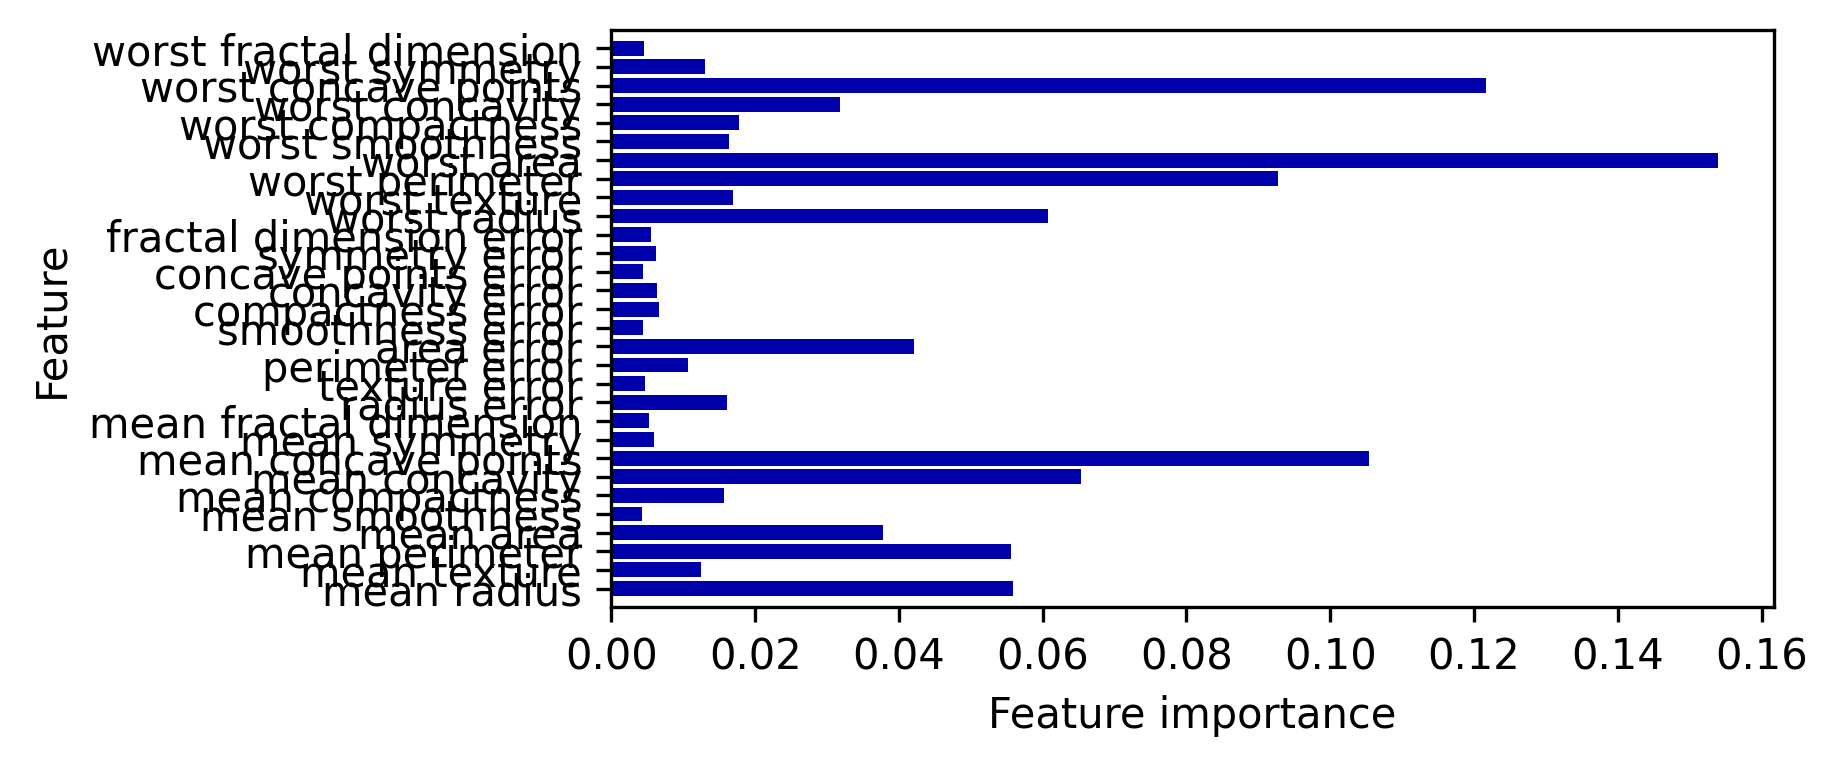

In [7]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


plot_feature_importances_cancer(forest)

###### Strengths, weaknesses, and parameters

#### Gradient Boosted Regression Trees (Gradient Boosting Machines)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)


print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


In [9]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [10]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.2)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


Accuracy on training set: 0.995
Accuracy on test set: 0.986


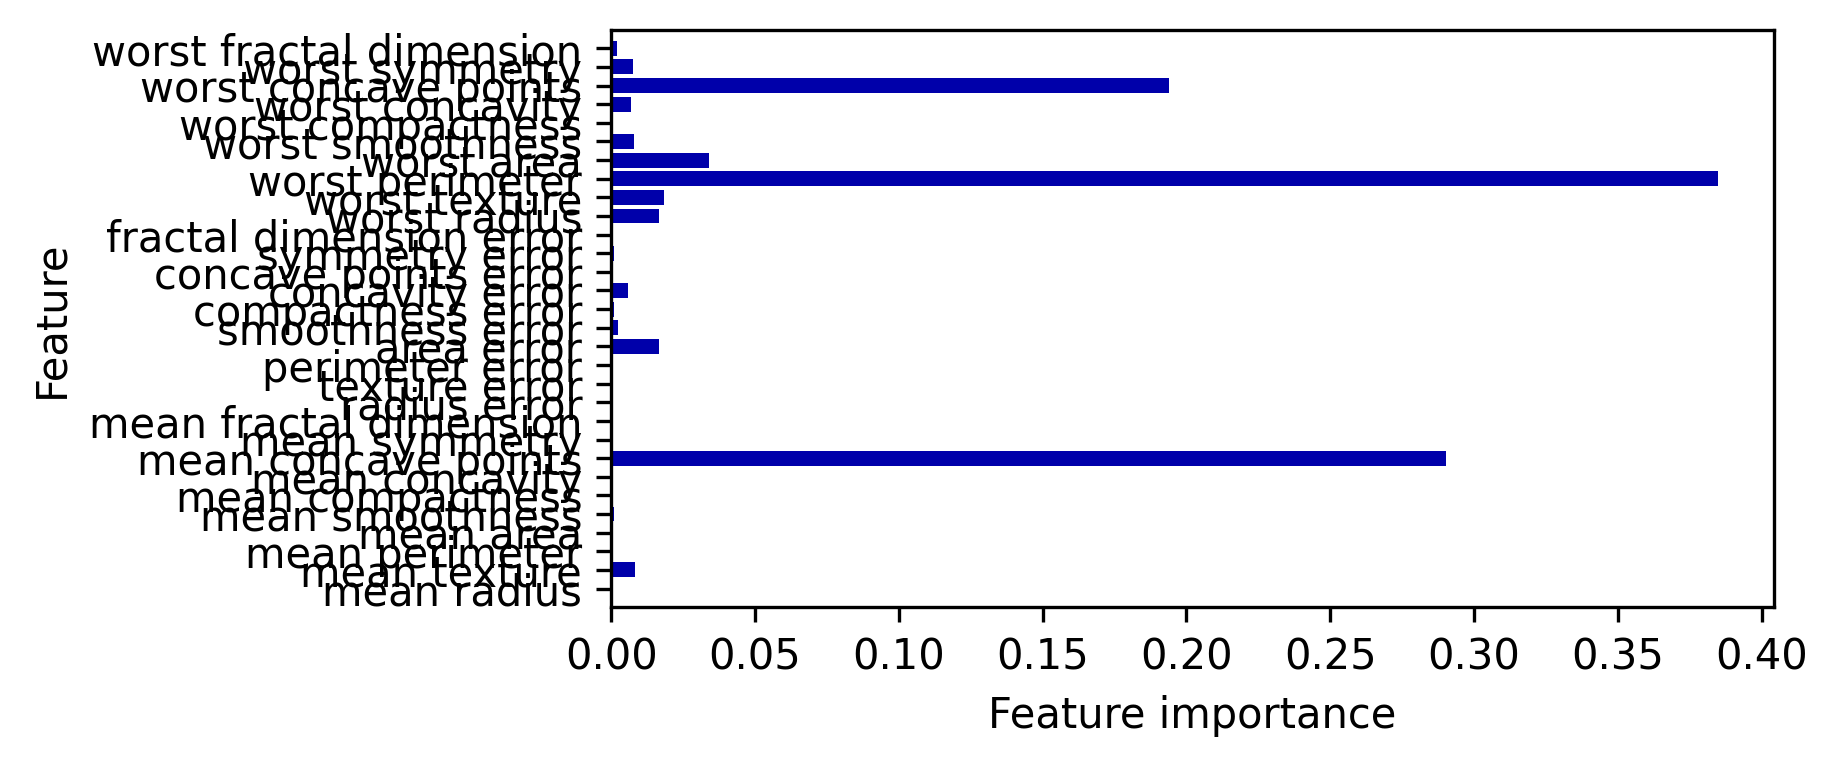

In [11]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1,learning_rate=.2)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))
plot_feature_importances_cancer(gbrt)

In [12]:
# Try grid search cross validation on the gradient boosted tree


In [13]:
# Try grid search on random forest



In [14]:
# display the out-of-sample accuracy from the CV-ed RF and GBRT

In [15]:
# display out-of-sample false negative rate and false positive rate from each CV-ed model


Try random forest or gradient boosted trees on the mortgage data from last time!